# Bootstrapping a Proportion

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1g2pmfg/comment/lruz2xp).

> How do I use bootstrapping to generate confidence intervals for a proportion/ratio? The situation is this:
>
> I obtain samples of text with differing numbers of lines. From several tens to over a million. I have no control over how many lines there are in any given sample. Each line of each sample may or may not contain a string S. Counting lines according to S presence or S absence generates a ratio of S to S' for that sample. I want to use bootstrapping to calculate confidence intervals for the found ratio (which of course will vary with sample size).
>
> To do this I could either:
>
> A. Literally resample (10,000 times) of size (say) 1,000 from the original sample (with replacement) then categorise S (and S'), and then calculate the ratio for each resample, and finally identify highest and lowest 2.5% (for 95% CI), or
>
> B. Generate 10,000 samples of 1,000 random numbers between 0 and 1, scoring each stochastically as above or below original sample ratio (equivalent to S or S'). Then calculate CI as in A.
>
>Programmatically A is slow and B is very fast. Is there anything wrong with doing B? The confidence intervals generated by each are almost identical.

The answer to the immediate question is that A and B are equivalent, so there's nothing wrong with B.
But in follow-up responses, a few related questions were raised:

1) Is resampling a good choice for this problem?

2) What size should the resamplings be?

3) How many resamplings do we need?

I don't think resampling is really necessary here, and I'll show some alternatives.
And I'll answer the other questions along the way.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/XXX.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [64]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py');

'utils.py'

In [65]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

## Pallor and Probability

As an example, let's use one of the exercises from *Think Python*:

> *The Count of Monte Cristo* is a novel by Alexandre Dumas that is considered a classic. Nevertheless, in the introduction of an English translation of the book, the writer Umberto Eco confesses that he found the book to be “one of the most badly written novels of all time”.
>
> In particular, he says it is “shameless in its repetition of the same adjective,” and mentions in particular the number of times “its characters either shudder or turn pale.”
>
> To see whether his objection is valid, let’s count the number number of lines that contain the word pale in any form, including pale, pales, paled, and paleness, as well as the related word pallor. Use a single regular expression that matches all of these words and no others.

The following cell downloads the text of the book from Project Gutenberg.

In [202]:
download('https://www.gutenberg.org/cache/epub/1184/pg1184.txt');

We'll use the following functions to remove the additional material that appears before and after the text of the book.

In [203]:
def is_special_line(line):
    return line.startswith('*** ')

In [204]:
def clean_file(input_file, output_file):
    reader = open(input_file)
    writer = open(output_file, 'w')

    for line in reader:
        if is_special_line(line):
            break

    for line in reader:
        if is_special_line(line):
            break
        writer.write(line)
        
    reader.close()
    writer.close()

clean_file('pg1184.txt', 'pg1184_cleaned.txt')

And we'll use the following function to count the number of lines that contain a particular pattern of characters.

In [205]:
import re

def count_matches(lines, pattern):
    count = 0
    for line in lines:
        result = re.search(pattern, line)
        if result != None:
            count += 1
    return count

`readlines` reads the file and creates a list of strings, one for each line.

In [206]:
lines = open('pg1184_cleaned.txt').readlines()
n = len(lines)
n

61310

There are about 61,000 lines in the file.

The following pattern matches "pale" and several related words.

In [207]:
pattern = r'\b(pale|pales|paled|paleness|pallor)\b'
k = count_matches(lines, pattern)
k

223

These words appear in 223 lines of the file.

In [208]:
p_est = k / n
p_est

0.0036372533028869677

So the estimated proportion is about 0.0036.
To quantify the precision of that estimate, we'll compute a 90% confidence interval.

First we'll use what OP called A, resampling the lines of the file.
The following function takes a list of lines and selects a sample, with replacement, that has the same size.

In [209]:
def resample(lines):
    return np.random.choice(lines, len(lines), replace=True)

In a resampling, the same line can appear more than once, and some lines might not appear at all.
So in any resampling, the forbidden words might appear more times than in the original text, or fewer.
Here's an example

In [218]:
np.random.seed(1)
count_matches(resample(lines), pattern)

201

In this resampling, the words appear in 201 lines, fewer than in the original (223), but not by much.

If we repeat this process many times, we can compute a sample of possible values of `k`.
Because this method is slow, we'll only repeat it 101 times.

In [219]:
ks_resampling = [count_matches(resample(lines), pattern) for i in range(101)]

With these different values of `k`, we can divide by `n` to get the corresponding values of `p`. 

In [220]:
ps_resampling = np.array(ks_resampling) / n

To see what the distribution of those values looks like, we'll plot the CDF.

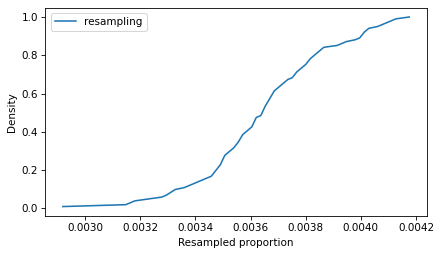

In [221]:
from empiricaldist import Cdf

Cdf.from_seq(ps_resampling).plot(label='resampling')
decorate(xlabel='Resampled proportion', ylabel='Density')

So that's the sampling distribution of the proportion.
We could use it to compute a confidence interval, but let's try the other method first.

Resampling the lines and searching them to see which ones contain the forbidden words is not very efficient.
We already know that `k` out of `n` of them contain the words, so we can use the binomial distribution to compute the sampling distribution more directly.

Suppose we draw lines from a large population where the proportion that contain the words is `k/n`, which is `p_est`.
If we draw another sample with size `n`, the value of `k` follows a binomial distribution with parameters `n` and `p_est`.
We can draw a sample from this distribution like this:

In [222]:
from scipy.stats import binom

ks_binom = binom(n, p_est).rvs(10001)

And compute the corresponding sample of proportions.

In [223]:
ps_binom = np.array(ks_binom) / n

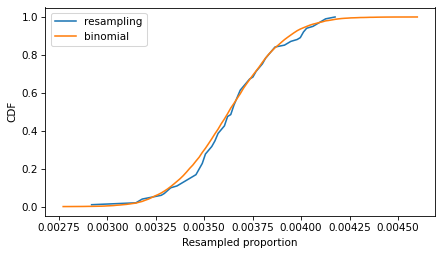

In [224]:
Cdf.from_seq(ps_resampling).plot(label='resampling')
Cdf.from_seq(ps_binom).plot(label='binomial')
decorate(xlabel='Resampled proportion', ylabel='CDF')

The two methods are equivalent.
If we run the resampling method longer, the two distributions converge.

To compute a 90% confidence interval, we can use the values we sampled from the binomial distribution.

In [217]:
np.percentile(ps_binom, [5, 95])

array([0.0032458 , 0.00404502])

Or we can use the inverse CDF of the binomial distribution, which is even faster than drawing a sample, and it's deterministic -- that is, we get the same result every time, with no randomness.

In [107]:
binom(n, p_est).ppf([0.05, 0.95]) / n

array([0.0032458 , 0.00404502])

Using the inverse CDF of the binomial distribution is a good way to compute confidence intervals.
But before we get to that, let's see how resampling behaves as we increase the sample size and the number of iterations.

## Sample Size

As the sample size increases, the confidence interval gets smaller.
In the example, the sample size is more than 60,000, so the CI is very small.
The following figure shows what it looks like for more moderate sample sizes, using `p=0.1` as an example.

50 [0.04 0.18]
500 [0.078 0.122]
5000 [0.0932 0.1068]


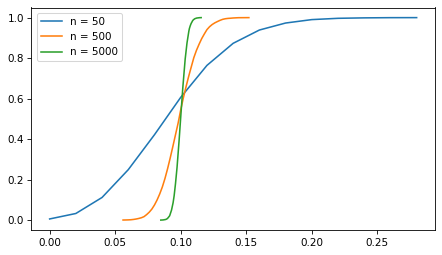

In [225]:
from empiricaldist import Cdf

p = 0.1
ns = [50, 500, 5000]

for n in ns:
    k = int(n * p)
    ks = binom(n, p).rvs(10001)
    ps = ks / n
    Cdf.from_seq(ps).plot(label=f"n = {n}")
    print(n, np.percentile(ps, [5, 95]))
    
decorate()

With resampling methods, it is important to draw samples with the same size as the original dataset -- otherwise the result is wrong.

But the number of iterations doesn't matter as much.
The following figure shows the sampling distribution if we run the sampling process 101, 1001, and 10,001 times.

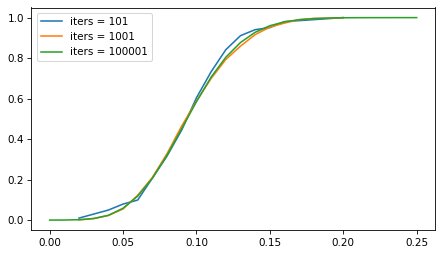

In [227]:
p = 0.1
n = 100
iter_seq = [101, 1001, 100001]

for iters in iter_seq:
    k = int(n * p)
    ks = binom(n, p).rvs(iters)
    ps = ks / n
    Cdf.from_seq(ps).plot(label=f"iters = {iters}")
    
decorate()

The sampling distribution is the same, regardless of how many iterations we run.
But with more iterations, we get a better picture of the distribution and a more precise estimate of the confidence interval.

For most problems, 1001 iterations is enough, but you can generate larger samples quickly, go ahead.

However, for this problem, resampling isn't really necessary.
As we've seen, we can use the binomial distribution to compute a CI without drawing a random sample at all.
Also, for this problem, there are approximations that are even easier to compute, although they come with some caveats.

## Approximations

If `n` is large and `p` is not too close to 0 or 1, the sampling distribution of a proportion is well approximated by a normal distribution, and we can approximate a confidence interval with just a few calculation.

For a given confidence level, we can use the inverse CDF of the normal distribution to compute a $z$ score, which is the number of standard deviations the CI should span -- positive and negative -- in order to include the given confidence.

In [159]:
from scipy.stats import norm

confidence = 0.9
z = norm.ppf(1 - (1 - confidence) / 2)
z

1.6448536269514722

Now we can use the following function, which uses this `z` score, `p`, and `n` to compute the confidence interval.

In [133]:
def confidence_interval_normal_approx(k, n):
    # Calculate proportion
    p = k / n
    
    # Calculate margin of error
    margin_of_error = z * np.sqrt(p * (1 - p) / n)
    
    # Confidence interval
    lower_bound = p - margin_of_error
    upper_bound = p + margin_of_error
    return lower_bound, upper_bound

To test it, we'll compute `n` and `k` for the example again.

In [233]:
n = len(lines)
k = count_matches(lines, pattern)
n, k

(61310, 223)

Here's the confidence interval based on the normal approximation.

In [234]:
ci_normal = confidence_interval_normal_approx(k, n)
ci_normal

(0.003237348046298746, 0.00403715855947519)

In the example, `n` is large, which is good for the normal approximation, but `p` is small, which is bad.
So it's not obvious whether we can trust the approximation.

An alternative that's more robust is the Wilson score interval, which is reliable for value of `p` close to 0 and 1, and sample sizes bigger than about 5.

In [235]:
def wilson_score_interval(k, n):
    
    # Proportion estimate
    p_hat = k / n
    
    # Common terms
    factor = z**2 / n
    denominator = 1 + factor
    center_adjustment = p_hat + factor / 2
    margin_adjustment = z * np.sqrt((p_hat * (1 - p_hat) + factor / 4) / n)
    
    # Calculate the lower and upper bounds
    lower_bound = (center_adjustment - margin_adjustment) / denominator
    upper_bound = (center_adjustment + margin_adjustment) / denominator
    
    return lower_bound, upper_bound

Here's the 90% CI based on Wilson scores.

In [236]:
ci_wilson = confidence_interval_wilson_score(k, n)
ci_wilson

(0.003258053185411942, 0.0040602593809138865)

Another alternative is the Clopper-Pearson interval, which is what we computed earlier with the inverse CDF of the binomial distribution.
Here's a function that computes it.

In [137]:
from scipy.stats import binom

def confidence_interval_exact_binomial(k, n, confidence=0.9):
    # Calculate alpha value for the two-sided interval
    alpha = 1 - confidence
    
    # Calculate lower and upper bounds using binom.ppf for exact binomial CI
    lower_bound = binom.ppf(alpha / 2, n, k / n) / n if k > 0 else 0
    upper_bound = binom.ppf(1 - alpha / 2, n, k / n) / n if k < n else 1
    
    return lower_bound, upper_bound

And here's the interval we get.

In [ ]:
ci_binomial = confidence_interval_exact_binomial(k, n)
ci_binomial

One final alternative is the Jeffreys interval, which is derived from Bayes's Theorem.
If we observe `k` successes out of `n` attempts, the sampling distribution of the proportion is a beta distribution with parameters `a = k + 1/2` and `b = n - k + 1/2`.
So we can use the inverse CDF of the beta distribution to compute a CI.

In [143]:
from scipy.stats import beta

def bayesian_confidence_interval_beta(k, n):
    # Alpha for the two-tailed interval
    alpha = 1 - confidence
    
    # Beta posterior parameters (assuming a uniform prior, Beta(1, 1))
    a, b = k + 1, n - k + 1
    
    # Calculate lower and upper bounds
    lower_bound = beta.ppf(alpha / 2, a, b)
    upper_bound = beta.ppf(1 - alpha / 2, a, b)
    
    return lower_bound, upper_bound

And here's the interval we get.

In [144]:
ci_beta = bayesian_confidence_interval_beta(k, n)
ci_beta

(0.0032620765334407924, 0.004063218038466101)

The following figure shows the four intervals we just computed graphically.

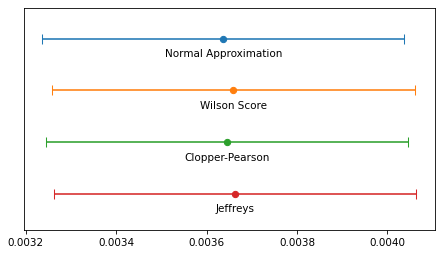

In [238]:
intervals = {
    'Normal Approximation': ci_normal,
    'Wilson Score': ci_wilson,
    'Clopper-Pearson': ci_binomial,
    'Jeffreys': ci_beta
}
y_pos = np.arange(len(intervals))

# Create horizontal error bars for each interval
for i, (label, (lower, upper)) in enumerate(intervals.items()):
    middle = (lower + upper) / 2
    xerr = [[(middle - lower)], [(upper - middle)]]
    plt.errorbar(x=middle, y=i-0.2, xerr=xerr,
                fmt='o', capsize=5)
    plt.text(middle, i, label, ha='center', va='top')
    
plt.gca().invert_yaxis()
plt.ylim([3.5, -0.8])
plt.yticks([])
decorate()

In this example, because `n` is so large, the intervals are all similar -- the differences are too small to matter in practice.
For smaller values of `n`, the normal approximation becomes unreliable, and for very small values, none of them are reliable.

The normal approximation and Wilson scores are easy and fast to compute.
On my modest old laptop, they take 1-2 microseconds.

In [239]:
%timeit confidence_interval_normal_approx(k, n)

1.02 µs ± 9.69 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [140]:
%timeit confidence_interval_wilson_score(k, n)

1.91 µs ± 10.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Evaluating the inverse CDF of the binomial and beta distributions is a more complex computation, taking about 100  longer.

In [240]:
%timeit confidence_interval_exact_binomial(k, n)

184 µs ± 5.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [241]:
%timeit bayesian_confidence_interval_beta(k, n)

247 µs ± 2.79 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


But 100 times longer is still less than 3 microseconds, so unless you need to compute millions of confidence intervals per second, the difference in computation time doesn't matter.

## Discussion

If you took a statistics class and learned one of these method, you probably learned the normal approximation.
The reason is that it is easy to explain and it's pedagogically tempting because it makes use of the Central Limit Theorem (or a form of it).
But in my opinion it should never be used in practice because it is dominated by the Wilson score interval -- that is, it is worse than Wilson in several ways and better in none.

In my opinion, the Clopper-Pearson interval is also easy to explain, but the binomial distribution is discrete, so when `n` is small, there are few possible values of `k`, and therefore few possible values of `p` -- and the interval can be wider than it needs to be.

The Jeffreys interval is based on Bayesian statistics, so it takes a little more explaining.
But it behaves well for all values of `n` and `p`.
And when `n` is small, it can be extended to take advantage of background information about likely values of `p`.

For these reasons, the Jeffreys interval is my usual choice, but there is one condition where I would use the Wilson score interval instead -- working in a computational environment where I don't have an implementation of the inverse CDF of the beta distribution.
Apparently that's the case for OP, who is working in LiveCode, which doesn't provide a lot of math and statistics libraries.

So here's a LiveCode implementation of the Wilson score interval (generated by ChatGPT).

```LiveCode
-- Function to calculate the z-score for a 95% confidence level (z ≈ 1.96)
function zScore
    return 1.96
end zScore

-- Function to calculate the Wilson Score Interval with distinct bounds
function wilsonScoreInterval k n
    -- Calculate proportion of successes
    put k / n into p
    put zScore() into z
    
    -- Common term for the interval calculation
    put (z^2 / n) into factor
    put (p + factor / 2) / (1 + factor) into adjustedCenter
    
    -- Asymmetric bounds
    put sqrt(p * (1 - p) / n + factor / 4) into sqrtTerm
    
    -- Lower bound calculation
    put adjustedCenter - (z * sqrtTerm / (1 + factor)) into lowerBound
    
    -- Upper bound calculation
    put adjustedCenter + (z * sqrtTerm / (1 + factor)) into upperBound
    
    return lowerBound & comma & upperBound
end wilsonScoreInterval
```

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)